In [150]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# Feature
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors

# Modeling
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv1D, GlobalMaxPooling1D, Input, Dense, concatenate, Activation
from tensorflow.keras.layers import Embedding
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
# Membaca data
train_data = pd.read_csv('../../Data/5. Split/train_data.csv')
validation_data = pd.read_csv('../../Data/5. Split/validation_data.csv')
test_data = pd.read_csv('../../Data/5. Split/test_data.csv')

In [152]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data.text_manual_replaced
y_train = train_data.label

x_validation = validation_data.text_manual_replaced
y_validation = validation_data.label

x_test = test_data.text_manual_replaced
y_test = test_data.label

TaggedDocument

In [153]:
def labelize_comments_ug(comments, label):
    """
    Fungsi ini mengonversi setiap komentar YouTube menjadi objek TaggedDocument 
    yang terdiri dari kata-kata dalam komentar dan label/tag yang terkait dengan komentar tersebut.
    """
    result = []
    prefix = label
    for i, c in zip(comments.index, comments):
        result.append(TaggedDocument(c.split(), [prefix + '_%s' % i]))
    return result


In [154]:
# Menggabungkan semua data komentar (latih, validasi, dan uji)
all_comments = pd.concat([x_train, x_validation, x_test])

# Mengonversi semua komentar YouTube menjadi objek TaggedDocument
all_comments_w2v = labelize_comments_ug(all_comments, 'all')

Word2Vec

Word2Vec dengan arsitektur Continuous Bag of Words (CBOW)

In [155]:
# Jumlah core CPU yang tersedia
cores = multiprocessing.cpu_count()

# Membuat model Word2Vec dengan arsitektur CBOW
model_ug_cbow = Word2Vec(
    sg=0,  # Menggunakan CBOW (sg=0)
    vector_size=100,  # Ukuran vektor fitur
    negative=5,  # Jumlah negative sampling
    window=2,  # Jarak maksimum antara kata target dan kata-kata yang mengelilinginya
    min_count=1,  # Minimum jumlah kemunculan kata untuk dimasukkan ke dalam model
    workers=cores,  # Jumlah worker yang akan digunakan
    alpha=0.065,  # Learning rate awal
    min_alpha=0.065,  # Learning rate minimum
    hs=1,  # Menggunakan hierarchical softmax
)

# Membangun kosakata dari semua komentar yang telah dikonversi menjadi TaggedDocument
model_ug_cbow.build_vocab([x.words for x in tqdm(all_comments_w2v)])

100%|██████████| 4776/4776 [00:00<00:00, 1197870.95it/s]


In [156]:
%%time
# Melatih model Word2Vec dengan arsitektur CBOW sebanyak 10 epoch 
for epoch in range(30):
    # Mengacak urutan data untuk setiap epoch
    shuffled_data = utils.shuffle([x.words for x in tqdm(all_comments_w2v)])
    
    # Melatih model dengan data yang telah diacak
    model_ug_cbow.train(shuffled_data, total_examples=len(all_comments_w2v), epochs=1)
    
    # Mengurangi learning rate sebesar 0.002 setiap epoch
    model_ug_cbow.alpha -= 0.002
    
    # Menyesuaikan learning rate minimum agar sama dengan learning rate saat ini
    model_ug_cbow.min_alpha = model_ug_cbow.alpha


100%|██████████| 4776/4776 [00:00<00:00, 1597193.10it/s]


CPU times: total: 9.31 s
Wall time: 2.64 s


In [157]:
# Membuat model Word2Vec dengan arsitektur Skip-gram
model_ug_sg = Word2Vec(
    sg=1,  # Menggunakan Skip-gram (sg=1)
    vector_size=100,  # Ukuran vektor fitur
    negative=5,  # Jumlah negative sampling
    window=2,  # Jarak maksimum antara kata target dan kata-kata yang mengelilinginya
    min_count=1,  # Minimum jumlah kemunculan kata untuk dimasukkan ke dalam model
    workers=cores,  # Jumlah worker yang akan digunakan
    alpha=0.065,  # Learning rate awal
    min_alpha=0.065,  # Learning rate minimum
    hs=1,  # Menggunakan hierarchical softmax
)

# Membangun kosakata dari semua komentar yang telah dikonversi menjadi TaggedDocument
model_ug_sg.build_vocab([x.words for x in tqdm(all_comments_w2v)])


100%|██████████| 4776/4776 [00:00<00:00, 2393594.92it/s]


In [158]:
%%time
# Melatih model Word2Vec dengan arsitektur Skip-gram sebanyak 10 epoch
for epoch in range(30):
    # Mengacak urutan data untuk setiap epoch
    shuffled_data = utils.shuffle([x.words for x in tqdm(all_comments_w2v)])
    
    # Melatih model dengan data yang telah diacak
    model_ug_sg.train(shuffled_data, total_examples=len(all_comments_w2v), epochs=1)
    
    # Mengurangi learning rate sebesar 0.002 setiap epoch
    model_ug_sg.alpha -= 0.002
    
    # Menyesuaikan learning rate minimum agar sama dengan learning rate saat ini
    model_ug_sg.min_alpha = model_ug_sg.alpha


100%|██████████| 4776/4776 [00:00<00:00, 2395598.65it/s]


CPU times: total: 19.2 s
Wall time: 3.78 s


In [159]:
# Menyimpan model Word2Vec CBOW yang telah dilatih
model_ug_cbow.save('./../../Model/w2v_model_ug_cbow.word2vec')

# Menyimpan model Word2Vec Skip-gram yang telah dilatih
model_ug_sg.save('./../../Model/w2v_model_ug_sg.word2vec')

In [160]:
# Memuat model Word2Vec CBOW yang telah disimpan
model_ug_cbow = KeyedVectors.load('./../../Model/w2v_model_ug_cbow.word2vec')

# Memuat model Word2Vec Skip-gram yang telah disimpan
model_ug_sg = KeyedVectors.load('./../../Model/w2v_model_ug_sg.word2vec')

In [161]:
# Menghitung jumlah kata unik dalam model Word2Vec CBOW
unique_words_count = len(model_ug_cbow.wv.index_to_key)

# Menampilkan jumlah kata unik
print(unique_words_count)

7350


In [162]:
embeddings_index = {}

# Menggabungkan kedua embeddings dari model CBOW dan Skip-gram untuk setiap kata unik
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

# Menampilkan jumlah vektor kata yang ditemukan
print('Found %s word vectors.' % len(embeddings_index))

Found 7350 word vectors.


In [163]:
# Membuat tokenizer dengan jumlah kata maksimum 20.000
tokenizer = Tokenizer(num_words=1500)  # num_words adalah jumlah kosakata yang ingin digunakan

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

In [164]:
# Menghitung jumlah kata unik dalam tokenizer
unique_token_count = len(tokenizer.word_index)

# Menampilkan jumlah kata unik
print(unique_token_count)

6287


In [165]:
# Menampilkan 5 teks pertama dari data latih (x_train)
for x in x_train[:5]:
    print(x)

obat yang larang kan sudah edar tahun banyak anak anak indonesia kalau panas batuk minum obat sebut baru sekarang ramai semua obat makan yang keluar edar ada ijin bpom edar juga ecek kadar apa saja yang kandung makan obat sebut kalau kadar nya enggak rugi masyarakat baru edar kalau bpom balik sudah makan banyak korban baru cek tarik pasar kan makan obat obat yang periksa parah sama badan yang satu sehat tubuh rakyat indonesia makan obat obat yang mutu lewat bpom yang beri amanah sehat rakyat indonesia makan obat obat yang halal kualitas salam waras
negara kumuh bersih hari sangat jauh sehat jorok kok sirup yang jadi kambing hitam
ada yang rencana tiba tiba ada yang jual obat luar dalam
gelar badut milik kominfo sekarang pindah menkes gyg menteri apa iya
iya bikin kacau lagi


In [166]:
# Menampilkan urutan indeks kata dari teks pertama dalam data latih (sequences)
print(sequences[:1])

[[1, 2, 109, 34, 13, 85, 56, 21, 3, 3, 22, 11, 101, 37, 6, 1, 119, 33, 24, 462, 25, 1, 40, 2, 296, 85, 44, 291, 16, 85, 46, 1000, 723, 10, 17, 2, 117, 40, 1, 119, 11, 723, 12, 5, 451, 93, 33, 85, 11, 16, 367, 13, 40, 21, 168, 33, 110, 238, 354, 34, 40, 1, 1, 2, 135, 324, 30, 344, 2, 136, 31, 332, 161, 22, 40, 1, 1, 2, 368, 16, 2, 127, 1477, 31, 161, 22, 40, 1, 1, 2, 835, 836, 493, 1478]]


In [167]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x.split()))

# length berisi panjang (jumlah kata) dari setiap teks dalam data latih

In [168]:
# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

# Menampilkan jumlah kata maksimum
print("Maximum number of words in a sentence:", max_word_count)

Maximum number of words in a sentence: 399


In [169]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = 400

# max_len digunakan untuk membatasi panjang urutan maksimum saat melakukan padding

In [170]:
# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

# Menampilkan bentuk tensor data latih yang telah dipad (x_train_seq)
print('Shape of padded data tensor:', x_train_seq.shape)

Shape of padded data tensor: (3820, 400)


In [171]:
# Menampilkan 5 sampel pertama dari data latih yang telah dipad (x_train_seq)
print(x_train_seq[:5])


[[   0    0    0 ...  836  493 1478]
 [   0    0    0 ...    9  494  463]
 [   0    0    0 ...    1  252  194]
 [   0    0    0 ...  279   10   52]
 [   0    0    0 ...   83  577   78]]


In [172]:
# Mengonversi teks dalam data validasi (x_validation) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_validation)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_val_seq = pad_sequences(sequences_val, maxlen=max_len)

# Komentar: Sekarang, x_val_seq berisi data validasi yang telah dipad dan siap digunakan

In [173]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

# Membuat matriks embedding kosong dengan bentuk (num_words, 200)
embedding_matrix = np.zeros((num_words, 200))

# Mengisi matriks embedding dengan vektor embedding yang sesuai dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Komentar: embedding_matrix sekarang berisi vektor embedding untuk seluruh kata unik dalam tokenizer.word_index

In [174]:
# Memeriksa kesetaraan antara vektor embedding ke-29 dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[29], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'? False


In [175]:
# Cari indeks kata 'baik' dalam tokenizer.word_index
baik_index = tokenizer.word_index.get('baik')

# Memeriksa kesetaraan antara vektor embedding kata 'baik' dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[baik_index], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'? True


Model klasifikasi multi-kelas

Eksperimen 1

In [176]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_validation_cat = to_categorical(y_validation + 1, num_classes=3)

In [177]:
# Membangun model klasifikasi multi-kelas
model_ptw2v_multi = Sequential()

# Menambahkan layer embedding dengan bobot pretrained dari embedding_matrix, panjang input max_len, dan ukuran vektor 200
# Menetapkan trainable=False agar bobot embedding tidak diperbarui selama pelatihan
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False)
model_ptw2v_multi.add(e)

# Mengaplikasikan operasi flatten untuk mengubah data menjadi vektor 1D
model_ptw2v_multi.add(Flatten())

# Menambahkan dense layer dengan 256 unit dan fungsi aktivasi ReLU
model_ptw2v_multi.add(Dense(256, activation='relu'))

# Menambahkan output layer dengan 3 unit (untuk 3 kelas) dan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_ptw2v_multi.add(Dense(3, activation='softmax'))


In [178]:
# Mengkompilasi model dengan categorical_crossentropy sebagai fungsi kerugian, optimizer 'adam', dan metrik evaluasi 'accuracy'
model_ptw2v_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [179]:
# Melatih model dengan data latih dan validasi, menggunakan 5 epoch dan batch size 32
model_ptw2v_multi.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 24s - loss: 0.9444 - accuracy: 0.5746 - val_loss: 0.9124 - val_accuracy: 0.6109 - 24s/epoch - 202ms/step
Epoch 2/5
120/120 - 23s - loss: 0.5199 - accuracy: 0.7969 - val_loss: 1.0249 - val_accuracy: 0.5753 - 23s/epoch - 193ms/step
Epoch 3/5
120/120 - 22s - loss: 0.2363 - accuracy: 0.9228 - val_loss: 1.2774 - val_accuracy: 0.5293 - 22s/epoch - 187ms/step
Epoch 4/5
120/120 - 22s - loss: 0.0938 - accuracy: 0.9801 - val_loss: 1.5101 - val_accuracy: 0.5502 - 22s/epoch - 187ms/step
Epoch 5/5
120/120 - 22s - loss: 0.0468 - accuracy: 0.9906 - val_loss: 1.6895 - val_accuracy: 0.5460 - 22s/epoch - 182ms/step


Eksperimen 2

In [180]:
# Membuat model sequential
model_ptw2v_multi = Sequential()

# Menambahkan layer embedding dengan panjang input max_len dan ukuran vektor 200
e = Embedding(num_words, 200, input_length=max_len)
model_ptw2v_multi.add(e)

# Mengaplikasikan operasi flatten untuk mengubah data menjadi vektor 1D
model_ptw2v_multi.add(Flatten())

# Menambahkan dense layer dengan 256 unit dan fungsi aktivasi ReLU
model_ptw2v_multi.add(Dense(256, activation='relu'))

# Mengganti fungsi aktivasi di output layer menjadi softmax untuk klasifikasi multi-kelas
# dan mengubah jumlah unit menjadi 3, yang sesuai dengan jumlah kelas Anda
model_ptw2v_multi.add(Dense(3, activation='softmax'))


In [181]:
# Kompilasi model dengan categorical_crossentropy sebagai fungsi kerugian
model_ptw2v_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [182]:
# Melatih model dengan data yang telah disesuaikan
model_ptw2v_multi.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 26s - loss: 1.0998 - accuracy: 0.5123 - val_loss: 0.9327 - val_accuracy: 0.5774 - 26s/epoch - 215ms/step
Epoch 2/5
120/120 - 24s - loss: 0.6348 - accuracy: 0.7592 - val_loss: 0.8526 - val_accuracy: 0.6381 - 24s/epoch - 199ms/step
Epoch 3/5
120/120 - 23s - loss: 0.3406 - accuracy: 0.8976 - val_loss: 0.9324 - val_accuracy: 0.6444 - 23s/epoch - 196ms/step
Epoch 4/5
120/120 - 24s - loss: 0.1749 - accuracy: 0.9571 - val_loss: 1.1137 - val_accuracy: 0.6276 - 24s/epoch - 197ms/step
Epoch 5/5
120/120 - 25s - loss: 0.0949 - accuracy: 0.9785 - val_loss: 1.2522 - val_accuracy: 0.6130 - 25s/epoch - 207ms/step


Eksperimen 3

In [183]:
# Membangun model klasifikasi multi-kelas
model_ptw2v_multi = Sequential()

# Menambahkan layer embedding dengan bobot pretrained dari embedding_matrix, panjang input max_len, dan ukuran vektor 200
# Menetapkan trainable=True agar bobot embedding diperbarui selama pelatihan
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)
model_ptw2v_multi.add(e)

# Mengaplikasikan operasi flatten untuk mengubah data menjadi vektor 1D
model_ptw2v_multi.add(Flatten())

# Menambahkan dense layer dengan 256 unit dan fungsi aktivasi ReLU
model_ptw2v_multi.add(Dense(256, activation='relu'))

# Menambahkan output layer dengan 3 unit dan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_ptw2v_multi.add(Dense(3, activation='softmax'))


In [184]:
# Mengkompilasi model dengan categorical_crossentropy sebagai fungsi kerugian, optimizer 'adam', dan metrik evaluasi 'accuracy'
model_ptw2v_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [185]:
# Melatih model dengan data latih dan validasi (one-hot encoded), menggunakan 5 epoch dan batch size 32
model_ptw2v_multi.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 25s - loss: 0.9705 - accuracy: 0.5647 - val_loss: 0.8822 - val_accuracy: 0.6151 - 25s/epoch - 205ms/step
Epoch 2/5
120/120 - 24s - loss: 0.5440 - accuracy: 0.7895 - val_loss: 1.0934 - val_accuracy: 0.5795 - 24s/epoch - 196ms/step
Epoch 3/5
120/120 - 24s - loss: 0.2636 - accuracy: 0.9115 - val_loss: 1.2306 - val_accuracy: 0.5900 - 24s/epoch - 196ms/step
Epoch 4/5
120/120 - 24s - loss: 0.1099 - accuracy: 0.9712 - val_loss: 1.4339 - val_accuracy: 0.5921 - 24s/epoch - 197ms/step
Epoch 5/5
120/120 - 24s - loss: 0.0552 - accuracy: 0.9874 - val_loss: 1.6623 - val_accuracy: 0.5669 - 24s/epoch - 196ms/step


Model Sequential

In [186]:
# Membuat struktur model Sequential
structure_test = Sequential()

# Menambahkan layer Embedding dengan 1500 kata dan dimensi 200
e = Embedding(num_words, 200, input_length=max_len)
structure_test.add(e)

# Menambahkan layer Conv1D dengan 100 filter, kernel_size 2, dan fungsi aktivasi ReLU
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menampilkan ringkasan struktur model
structure_test.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 400, 200)          1257600   
                                                                 
 conv1d_27 (Conv1D)          (None, 399, 100)          40100     
                                                                 
Total params: 1,297,700
Trainable params: 1,297,700
Non-trainable params: 0
_________________________________________________________________


In [187]:
# Membuat model Sequential
structure_test = Sequential()

# Membuat layer Embedding dan menambahkannya ke model
e = Embedding(num_words, 200, input_length=max_len)
structure_test.add(e)

# Menambahkan layer Conv1D ke model
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menambahkan layer GlobalMaxPooling1D ke model
structure_test.add(GlobalMaxPooling1D())

# Menampilkan ringkasan struktur model
structure_test.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 400, 200)          1257600   
                                                                 
 conv1d_28 (Conv1D)          (None, 399, 100)          40100     
                                                                 
 global_max_pooling1d_25 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
Total params: 1,297,700
Trainable params: 1,297,700
Non-trainable params: 0
_________________________________________________________________


Pemodelan CNN

In [188]:
# Membuat model Sequential
model_cnn_01_multi = Sequential()

# Menambahkan layer Embedding dengan matriks bobot yang sudah ada
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False)
model_cnn_01_multi.add(e)

# Menambahkan layer Conv1D
model_cnn_01_multi.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menambahkan layer GlobalMaxPooling1D
model_cnn_01_multi.add(GlobalMaxPooling1D())

# Menambahkan layer Dense dengan aktivasi ReLU
model_cnn_01_multi.add(Dense(256, activation='relu'))

# Menambahkan layer Dense dengan aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_01_multi.add(Dense(3, activation='softmax'))

In [189]:
# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn_01_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [190]:
# Melatih model dengan data latih dan validasi (gunakan y_train_cat dan y_validation_cat untuk label one-hot encoded)
model_cnn_01_multi.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 3s - loss: 0.9452 - accuracy: 0.5531 - val_loss: 0.8559 - val_accuracy: 0.6109 - 3s/epoch - 28ms/step
Epoch 2/5
120/120 - 3s - loss: 0.7038 - accuracy: 0.7123 - val_loss: 0.8447 - val_accuracy: 0.6381 - 3s/epoch - 22ms/step
Epoch 3/5
120/120 - 3s - loss: 0.5215 - accuracy: 0.7997 - val_loss: 1.0327 - val_accuracy: 0.6318 - 3s/epoch - 22ms/step
Epoch 4/5
120/120 - 3s - loss: 0.3602 - accuracy: 0.8751 - val_loss: 1.0775 - val_accuracy: 0.6360 - 3s/epoch - 22ms/step
Epoch 5/5
120/120 - 3s - loss: 0.2422 - accuracy: 0.9204 - val_loss: 1.2824 - val_accuracy: 0.6172 - 3s/epoch - 21ms/step


In [191]:
# Membuat model Sequential
model_cnn_02_multi = Sequential()

# Menambahkan layer Embedding
e = Embedding(num_words, 200, input_length=max_len)
model_cnn_02_multi.add(e)

# Menambahkan layer Conv1D
model_cnn_02_multi.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menambahkan layer GlobalMaxPooling1D
model_cnn_02_multi.add(GlobalMaxPooling1D())

# Menambahkan layer Dense dengan aktivasi ReLU
model_cnn_02_multi.add(Dense(256, activation='relu'))

# Menambahkan layer Dense output dengan aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_02_multi.add(Dense(3, activation='softmax'))


In [192]:
# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn_02_multi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [193]:
# Melatih model dengan data latih dan data validasi
model_cnn_02_multi.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 5s - loss: 0.9487 - accuracy: 0.5592 - val_loss: 0.8556 - val_accuracy: 0.6318 - 5s/epoch - 40ms/step
Epoch 2/5
120/120 - 4s - loss: 0.6443 - accuracy: 0.7461 - val_loss: 0.8046 - val_accuracy: 0.6569 - 4s/epoch - 34ms/step
Epoch 3/5
120/120 - 4s - loss: 0.4017 - accuracy: 0.8620 - val_loss: 0.8905 - val_accuracy: 0.6569 - 4s/epoch - 33ms/step
Epoch 4/5
120/120 - 4s - loss: 0.2136 - accuracy: 0.9338 - val_loss: 1.1385 - val_accuracy: 0.6444 - 4s/epoch - 32ms/step
Epoch 5/5
120/120 - 4s - loss: 0.0873 - accuracy: 0.9788 - val_loss: 1.3399 - val_accuracy: 0.6402 - 4s/epoch - 32ms/step


In [194]:
model_cnn_multi_reg = Sequential()

e = Embedding(num_words, 200, input_length=max_len)
model_cnn_multi_reg.add(e)

model_cnn_multi_reg.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01)))
model_cnn_multi_reg.add(GlobalMaxPooling1D())
model_cnn_multi_reg.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

# Menambahkan lapisan Dropout dengan tingkat dropout 0.5
model_cnn_multi_reg.add(Dropout(0.5))

model_cnn_multi_reg.add(Dense(3, activation='softmax'))

model_cnn_multi_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_multi_reg.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)


Epoch 1/5
120/120 - 6s - loss: 1.8896 - accuracy: 0.4516 - val_loss: 1.1415 - val_accuracy: 0.4874 - 6s/epoch - 46ms/step
Epoch 2/5
120/120 - 4s - loss: 0.9588 - accuracy: 0.6416 - val_loss: 0.9811 - val_accuracy: 0.6067 - 4s/epoch - 36ms/step
Epoch 3/5
120/120 - 4s - loss: 0.8161 - accuracy: 0.7092 - val_loss: 0.9387 - val_accuracy: 0.6444 - 4s/epoch - 35ms/step
Epoch 4/5
120/120 - 4s - loss: 0.7389 - accuracy: 0.7479 - val_loss: 0.9467 - val_accuracy: 0.6569 - 4s/epoch - 35ms/step
Epoch 5/5
120/120 - 4s - loss: 0.6833 - accuracy: 0.7759 - val_loss: 0.9843 - val_accuracy: 0.6318 - 4s/epoch - 35ms/step


In [195]:
# Membuat input layer dengan tipe data int32 dan dimensi (max_len,)
art_input = Input(shape=(max_len,), dtype='int32')

# Menambahkan lapisan Embedding
art_encoder = Embedding(num_words, 200, input_length=max_len)(art_input)

# Membuat cabang bigram dengan Conv1D dan GlobalMaxPooling1D
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(art_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)

# Membuat cabang trigram dengan Conv1D dan GlobalMaxPooling1D
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(art_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

# Membuat cabang fourgram dengan Conv1D dan GlobalMaxPooling1D
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(art_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)

# Menggabungkan ketiga cabang
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

# Menambahkan lapisan Dense dengan fungsi aktivasi ReLU dan regularisasi L2
merged = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(merged)

# Menambahkan lapisan Dropout untuk mengurangi overfitting
merged = Dropout(0.5)(merged)

# Menambahkan lapisan Dense kedua untuk klasifikasi multi-kelas
merged = Dense(3)(merged)

# Menambahkan lapisan Activation dengan fungsi aktivasi softmax
output = Activation('softmax')(merged)

# Membangun model dengan input dan output yang telah ditentukan
model_test = Model(inputs=[art_input], outputs=[output])

# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_test.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Menampilkan ringkasan struktur model
model_test.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_35 (Embedding)       (None, 400, 200)     1257600     ['input_4[0][0]']                
                                                                                                  
 conv1d_32 (Conv1D)             (None, 399, 100)     40100       ['embedding_35[0][0]']           
                                                                                                  
 conv1d_33 (Conv1D)             (None, 398, 100)     60100       ['embedding_35[0][0]']           
                                                                                            

In [196]:
# Menentukan jalur file untuk menyimpan bobot terbaik dan format nama file
filepath="./Best Weight/Train_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"

# Membuat objek ModelCheckpoint untuk memantau 'val_accuracy' dan menyimpan bobot terbaik
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Melatih model dengan data latihan dan validasi, serta menggunakan ModelCheckpoint sebagai callback
model_test.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, callbacks=[checkpoint])

Epoch 1/5
119/120 [============================>.] - ETA: 0s - loss: 2.6859 - accuracy: 0.4446
Epoch 1: val_accuracy improved from -inf to 0.49582, saving model to ./Best Weight\Train_best_weights.01-0.4958.hdf5
120/120 [==============================] - 14s 105ms/step - loss: 2.6811 - accuracy: 0.4445 - val_loss: 1.1353 - val_accuracy: 0.4958
Epoch 2/5
119/120 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.6295
Epoch 2: val_accuracy improved from 0.49582 to 0.62552, saving model to ./Best Weight\Train_best_weights.02-0.6255.hdf5
120/120 [==============================] - 12s 104ms/step - loss: 0.9871 - accuracy: 0.6301 - val_loss: 0.9694 - val_accuracy: 0.6255
Epoch 3/5
120/120 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.7136
Epoch 3: val_accuracy improved from 0.62552 to 0.64854, saving model to ./Best Weight\Train_best_weights.03-0.6485.hdf5
120/120 [==============================] - 14s 116ms/step - loss: 0.8447 - accuracy: 0.713

In [197]:
# Membangun model
model_cnn_04 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang dapat dilatih
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)
model_cnn_04.add(e)

# Menambahkan lapisan Conv1D
model_cnn_04.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))

# Menambahkan lapisan GlobalMaxPooling1D
model_cnn_04.add(GlobalMaxPooling1D())

# Menambahkan lapisan Dense pertama dengan fungsi aktivasi ReLU dan dropout
model_cnn_04.add(Dense(256, activation='relu'))
model_cnn_04.add(Dropout(0.6))  # Menambahkan dropout

# Menambahkan lapisan Dense kedua dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_04.add(Dense(3, activation='softmax'))

In [198]:
# Mengkompilasi model dengan fungsi loss 'categorical_crossentropy', optimizer 'adam', dan metrik evaluasi 'accuracy'
model_cnn_03.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [199]:
# Melatih model menggunakan data latihan dan validasi
model_cnn_03.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
120/120 - 5s - loss: 0.2332 - accuracy: 0.9783 - val_loss: 1.6887 - val_accuracy: 0.6527 - 5s/epoch - 44ms/step
Epoch 2/5
120/120 - 4s - loss: 0.2194 - accuracy: 0.9780 - val_loss: 1.7190 - val_accuracy: 0.6548 - 4s/epoch - 37ms/step
Epoch 3/5
120/120 - 4s - loss: 0.1966 - accuracy: 0.9853 - val_loss: 1.7580 - val_accuracy: 0.6485 - 4s/epoch - 36ms/step
Epoch 4/5
120/120 - 4s - loss: 0.2118 - accuracy: 0.9780 - val_loss: 1.8048 - val_accuracy: 0.6276 - 4s/epoch - 35ms/step
Epoch 5/5
120/120 - 4s - loss: 0.2155 - accuracy: 0.9738 - val_loss: 1.7832 - val_accuracy: 0.6318 - 4s/epoch - 35ms/step


In [200]:
from keras.callbacks import EarlyStopping

model_cnn_04 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang dapat dilatih
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)
model_cnn_04.add(e)

# Menambahkan lapisan Conv1D dengan regularisasi L2 dan Dropout
model_cnn_04.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01)))
model_cnn_04.add(Dropout(0.5))

# Menambahkan lapisan GlobalMaxPooling1D
model_cnn_04.add(GlobalMaxPooling1D())

# Menambahkan lapisan Dense pertama dengan fungsi aktivasi ReLU dan regularisasi L2
model_cnn_04.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_04.add(Dropout(0.5))

# Menambahkan lapisan Dense kedua dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_cnn_04.add(Dense(3, activation='softmax'))


In [201]:
model_cnn_04.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menambahkan EarlyStopping untuk menghentikan pelatihan jika akurasi validasi tidak meningkat
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [202]:
# Melatih model menggunakan data latihan dan validasi
model_cnn_04.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, callbacks=[early_stopping], verbose=2)

Epoch 1/5
120/120 - 6s - loss: 3.3606 - accuracy: 0.4819 - val_loss: 2.7729 - val_accuracy: 0.5879 - 6s/epoch - 50ms/step
Epoch 2/5
120/120 - 5s - loss: 2.3672 - accuracy: 0.6107 - val_loss: 2.0884 - val_accuracy: 0.6192 - 5s/epoch - 42ms/step
Epoch 3/5
120/120 - 5s - loss: 1.8002 - accuracy: 0.6545 - val_loss: 1.6482 - val_accuracy: 0.6653 - 5s/epoch - 41ms/step
Epoch 4/5
120/120 - 5s - loss: 1.4353 - accuracy: 0.6916 - val_loss: 1.4118 - val_accuracy: 0.6674 - 5s/epoch - 41ms/step
Epoch 5/5
120/120 - 5s - loss: 1.1931 - accuracy: 0.7149 - val_loss: 1.2589 - val_accuracy: 0.6569 - 5s/epoch - 41ms/step


In [203]:
comment_input = Input(shape=(max_len,), dtype='int32')

comment_encoder = Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=True)(comment_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(comment_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(comment_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1, kernel_regularizer=l2(0.01))(comment_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.2)(merged)
merged = Dense(3)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[comment_input], outputs=[output])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_38 (Embedding)       (None, 400, 200)     1257600     ['input_5[0][0]']                
                                                                                                  
 conv1d_37 (Conv1D)             (None, 399, 100)     40100       ['embedding_38[0][0]']           
                                                                                                  
 conv1d_38 (Conv1D)             (None, 398, 100)     60100       ['embedding_38[0][0]']           
                                                                                            

In [204]:
filepath="./Best Weight/CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train_cat, validation_data=(x_val_seq, y_validation_cat), epochs=5, batch_size=32, callbacks=[checkpoint])

Epoch 1/5
119/120 [============================>.] - ETA: 0s - loss: 5.1744 - accuracy: 0.5460
Epoch 1: val_accuracy improved from -inf to 0.60251, saving model to ./Best Weight\CNN_best_weights.01-0.6025.hdf5
120/120 [==============================] - 14s 105ms/step - loss: 5.1688 - accuracy: 0.5458 - val_loss: 3.2353 - val_accuracy: 0.6025
Epoch 2/5
119/120 [============================>.] - ETA: 0s - loss: 2.3490 - accuracy: 0.7022
Epoch 2: val_accuracy improved from 0.60251 to 0.65272, saving model to ./Best Weight\CNN_best_weights.02-0.6527.hdf5
120/120 [==============================] - 12s 103ms/step - loss: 2.3475 - accuracy: 0.7018 - val_loss: 1.9249 - val_accuracy: 0.6527
Epoch 3/5
120/120 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.7694
Epoch 3: val_accuracy did not improve from 0.65272
120/120 [==============================] - 13s 108ms/step - loss: 1.4427 - accuracy: 0.7694 - val_loss: 1.5936 - val_accuracy: 0.6464
Epoch 4/5
119/120 [==========

Evaluasi Pemodelan CNN

In [206]:
# Memuat model CNN terbaik yang telah disimpan sebelumnya
loaded_CNN_model = load_model('./Best Weight/CNN_best_weights.05-0.6548.hdf5')

# Evaluasi model menggunakan data validasi
val_loss, val_accuracy = loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation_cat)

15/15 [==============================] - 0s 21ms/step - loss: 1.3460 - accuracy: 0.6548


In [208]:
# Memuat model terlatih terbaik yang telah disimpan sebelumnya
train_model = load_model('./Best Weight/Train_best_weights.04-0.6506.hdf5')

# Evaluasi model menggunakan data validasi
val_loss, val_accuracy = train_model.evaluate(x=x_val_seq, y=y_validation_cat)

15/15 [==============================] - 0s 21ms/step - loss: 0.9540 - accuracy: 0.6506


In [209]:
# Mengkonversi teks dalam x_test menjadi urutan token dengan tokenizer
sequences_test = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan token agar memiliki panjang yang sama
x_test_seq = pad_sequences(sequences_test, maxlen=max_len)

# Mengubah label y_test menjadi bentuk one-hot encoding
y_test_cat = to_categorical(y_test + 1, num_classes=3) 

In [210]:
# Menilai model CNN yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
loaded_CNN_model_evaluation = loaded_CNN_model.evaluate(x=x_test_seq, y=y_test_cat)
print(f"Loaded CNN Model: Loss = {loaded_CNN_model_evaluation[0]}, Accuracy = {loaded_CNN_model_evaluation[1]}")

# Menilai model train yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
train_model_evaluation = train_model.evaluate(x=x_test_seq, y=y_test_cat)
print(f"Train Model: Loss = {train_model_evaluation[0]}, Accuracy = {train_model_evaluation[1]}")


15/15 [==============================] - 0s 21ms/step - loss: 1.3259 - accuracy: 0.6632
Loaded CNN Model: Loss = 1.3258721828460693, Accuracy = 0.6631799340248108
15/15 [==============================] - 0s 21ms/step - loss: 0.9486 - accuracy: 0.6360
Train Model: Loss = 0.9486376643180847, Accuracy = 0.6359832882881165


In [211]:
# Memprediksi label kelas menggunakan model CNN yang telah dilatih pada data test (x_test_seq)
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

# Memprediksi label kelas menggunakan model train yang telah dilatih pada data test (x_test_seq)
yhat_train = train_model.predict(x_test_seq)

15/15 [==============================] - 0s 20ms/step


In [212]:
# Mengkonversi prediksi probabilitas ke label kelas untuk kedua model
y_pred_cnn = np.argmax(yhat_cnn, axis=1) - 1
y_pred_train = np.argmax(yhat_train, axis=1) - 1

# Menghitung true label dari one-hot encoding
y_true = np.argmax(y_test_cat, axis=1) - 1

In [213]:
# Menampilkan classification report untuk kedua model
print("Classification Report (CNN Model):")
print(classification_report(y_true, y_pred_cnn))
print("Classification Report (Train Model):")
print(classification_report(y_true, y_pred_train))

Classification Report (CNN Model):
              precision    recall  f1-score   support

          -1       0.67      0.66      0.66       158
           0       0.70      0.73      0.72       180
           1       0.60      0.58      0.59       140

    accuracy                           0.66       478
   macro avg       0.66      0.66      0.66       478
weighted avg       0.66      0.66      0.66       478

Classification Report (Train Model):
              precision    recall  f1-score   support

          -1       0.63      0.63      0.63       158
           0       0.65      0.78      0.71       180
           1       0.62      0.46      0.53       140

    accuracy                           0.64       478
   macro avg       0.63      0.62      0.62       478
weighted avg       0.63      0.64      0.63       478



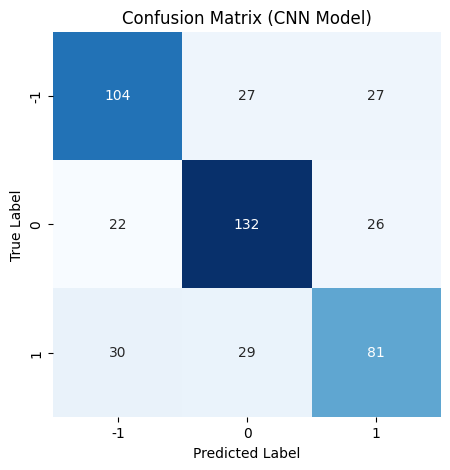

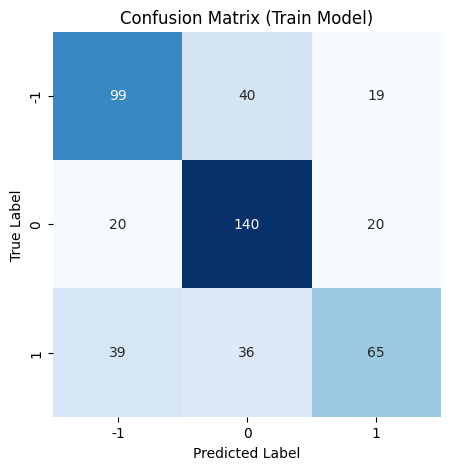

In [222]:
# Menghitung confusion matrix untuk kedua model
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
cm_train = confusion_matrix(y_true, y_pred_train)

# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_cnn, "Confusion Matrix (CNN Model)")
plot_cm(cm_train, "Confusion Matrix (Train Model)")

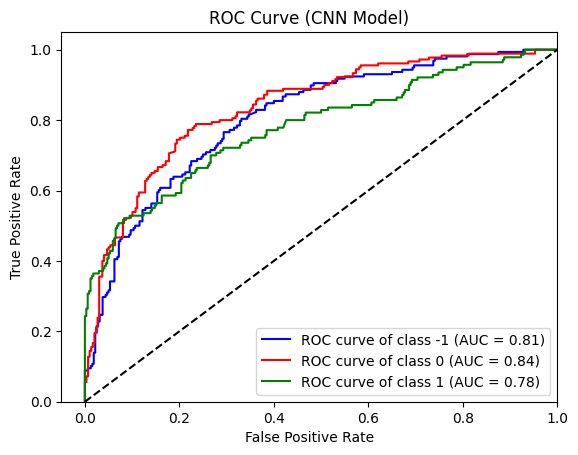

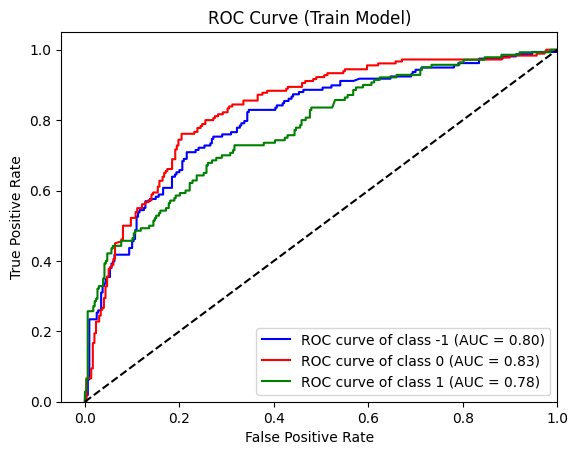

In [223]:
# Fungsi untuk menggambarkan ROC curve
def plot_roc_curve(y_true, y_score, n_classes, title):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])

    # Menghitung ROC curve dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menggambarkan ROC curve
    plt.figure()
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Menggambarkan ROC curve untuk kedua model
plot_roc_curve(y_true, yhat_cnn, n_classes=3, title='ROC Curve (CNN Model)')
plot_roc_curve(y_true, yhat_train, n_classes=3, title='ROC Curve (Train Model)')

Output

In [224]:
# Gabungkan data latih, data validasi, dan data uji
full_data = pd.concat([train_data, validation_data, test_data], axis=0)

# Prediksi pada keseluruhan data
sequences_full = tokenizer.texts_to_sequences(full_data['text_manual_replaced'])
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)
yhat_full_cnn = loaded_CNN_model.predict(x_full_seq)

# Konversi prediksi ke label kelas
yhat_full_cnn_classes = np.argmax(yhat_full_cnn, axis=1) - 1

# Tambahkan kolom baru ke DataFrame
full_data['predicted_sentiment'] = yhat_full_cnn_classes

full_data.head(10)

150/150 [==============================] - 5s 36ms/step


,text_manual_replaced,label,predicted_sentiment
0,obat yang larang kan sudah edar tahun banyak a...,-1,-1
1,negara kumuh bersih hari sangat jauh sehat jor...,-1,-1
2,ada yang rencana tiba tiba ada yang jual obat ...,0,0
3,gelar badut milik kominfo sekarang pindah menk...,0,0
4,iya bikin kacau lagi,-1,-1
5,kesalahn bepom kenapa enggak tliti dulu sebelu...,1,1
6,keliling nya palembang iya dokter bhsa nya cak...,0,0
7,baru muncul covid kabar nya karena demand obat...,-1,-1
8,mantap dokter ganteng selalu edukasi baik deng...,1,1
9,dokter mohon jawab kalo obat panas tempra obat...,0,0


In [217]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-CNN.csv", index=False)